# Abstract

The objective of this project was to check the performance of tsp solution provided in ".tour" or ".cyc" file. The data points co-ordinates are provided in tsp file.
Ideally, we should see travelling in straight line ie 180 degree and travelling to the nearest neighbour. But due to topography, we don't see that happening.

The data of points was provided in usa13509.tsp file(13509 data points) and the travelling solution in usa13509.cyc file.
Python and Jupyter Notebook were used to complete the analysis. Main libraries used for analysis: pandas, matplotlib and numpy.

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys

## Enter the filename, it expects both the filename.tsp and filename.opt.tour(or cyc) file to be present in the same directory 

#### Set "file" parameter to the file name(without any suffix) of tsp file and filetype as present("cyc" for .cyc and "tour" for .tour file). In .cyc file, the index is from 0 to (n-1) whereas in .tour file it was from 1 to n. Hence 1 has been added while processing cyc file.

In [2]:
file="usa13509"
filetype="cyc"
number_of_farthest_neighbour_connections_to_choose = 5

In [3]:
cities_set = []
solution_list = []
cities_tups = []
cities_dict = {}
tsp_solution = pd.Series([])

### Function which gets the tsp solution from tour file and populates the string solution_list

In [4]:
def get_cities_solution(listp, dimension, filetype):
    dimension = int(dimension)
    is_digit_string=lambda x:all(var.isdigit() for var in x.split())
    modified_str = ""
    modified_str=" ".join([x for x in listp if is_digit_string(x)])
    list_mod = modified_str.split()
    if filetype == "cyc":
        list_mod=list(map(int, list_mod))
        list_mod =list(map(lambda x:x+1, list_mod))
        list_mod=list(map(str, list_mod))
    for item in list_mod:
        if item.isdigit() and (int(item) in range(1, dimension+1)):
            item = item.strip()
            index = item
            if index not in solution_list:
                solution_list.append(index)
    return solution_list

### Function read_tsp_file: reads the file and stores each line in list

In [5]:
def read_tsp_file(file_name):
    tsp_file = file_name
    with open(tsp_file) as f:
        content = f.read().splitlines()
        cleaned = [x.lstrip() for x in content if x != ""]
        return cleaned

### Function get_coordinates: reads the list and get the co-ordinates of city and add it to dataframe. Change coordinates to complex to ease distance calculation.

In [6]:
def get_coordinates(lines, dimension):
    dimension = int(dimension)
    df = pd.DataFrame(columns=['City x-Coord', 'City y-Coord'])
    for item in lines:
        for num in range(1, dimension + 1):
            if item.startswith(str(num)):
                index, x_coord, y_coord = item.split()
                index = int(index)
                if (x_coord, y_coord) not in cities_set:
                    cities_set.append((float(x_coord), float(y_coord)))
                    df.loc[index] = [float(x_coord), float(y_coord)]
                    # Convert to complex so that computation of eucladian distance becomes easy
    df['coord'] = df['City x-Coord'] + df['City y-Coord'] * 1j
    return df

### Calculate dimension from the lines read from tsp file.

In [7]:
def calculate_dimension(in_list):
    non_numeric = re.compile(r'[^\d]+')
    for element in in_list:
        if element.startswith("DIMENSION"):
            return non_numeric.sub("", element)

## Start of main program

In [8]:
tsp_file_name = file+".tsp"
if filetype=="cyc":
    tour_file_name = file+".cyc"
else:
    tour_file_name = file+".opt.tour"
files = [tsp_file_name, tour_file_name]
for i in files:
    data=[]
    if not os.path.exists(i):
        print("File does not exist")
    data = read_tsp_file(i)
    if filetype=="tour" or i.endswith("tsp"):
        dimension = calculate_dimension(data)
    if i.endswith("tsp"):
        df = get_coordinates(data, dimension)
    elif i.endswith("tour") or i.endswith("cyc"):
        solution_list = get_cities_solution(data, dimension, filetype)

### Calculation of angle and plotting.

Here we calculate the angle of the route tsp solution provides. We see angle less than 70 is very less as expected, but as we proceed towards ideal condition ie 180, count increases considerably.

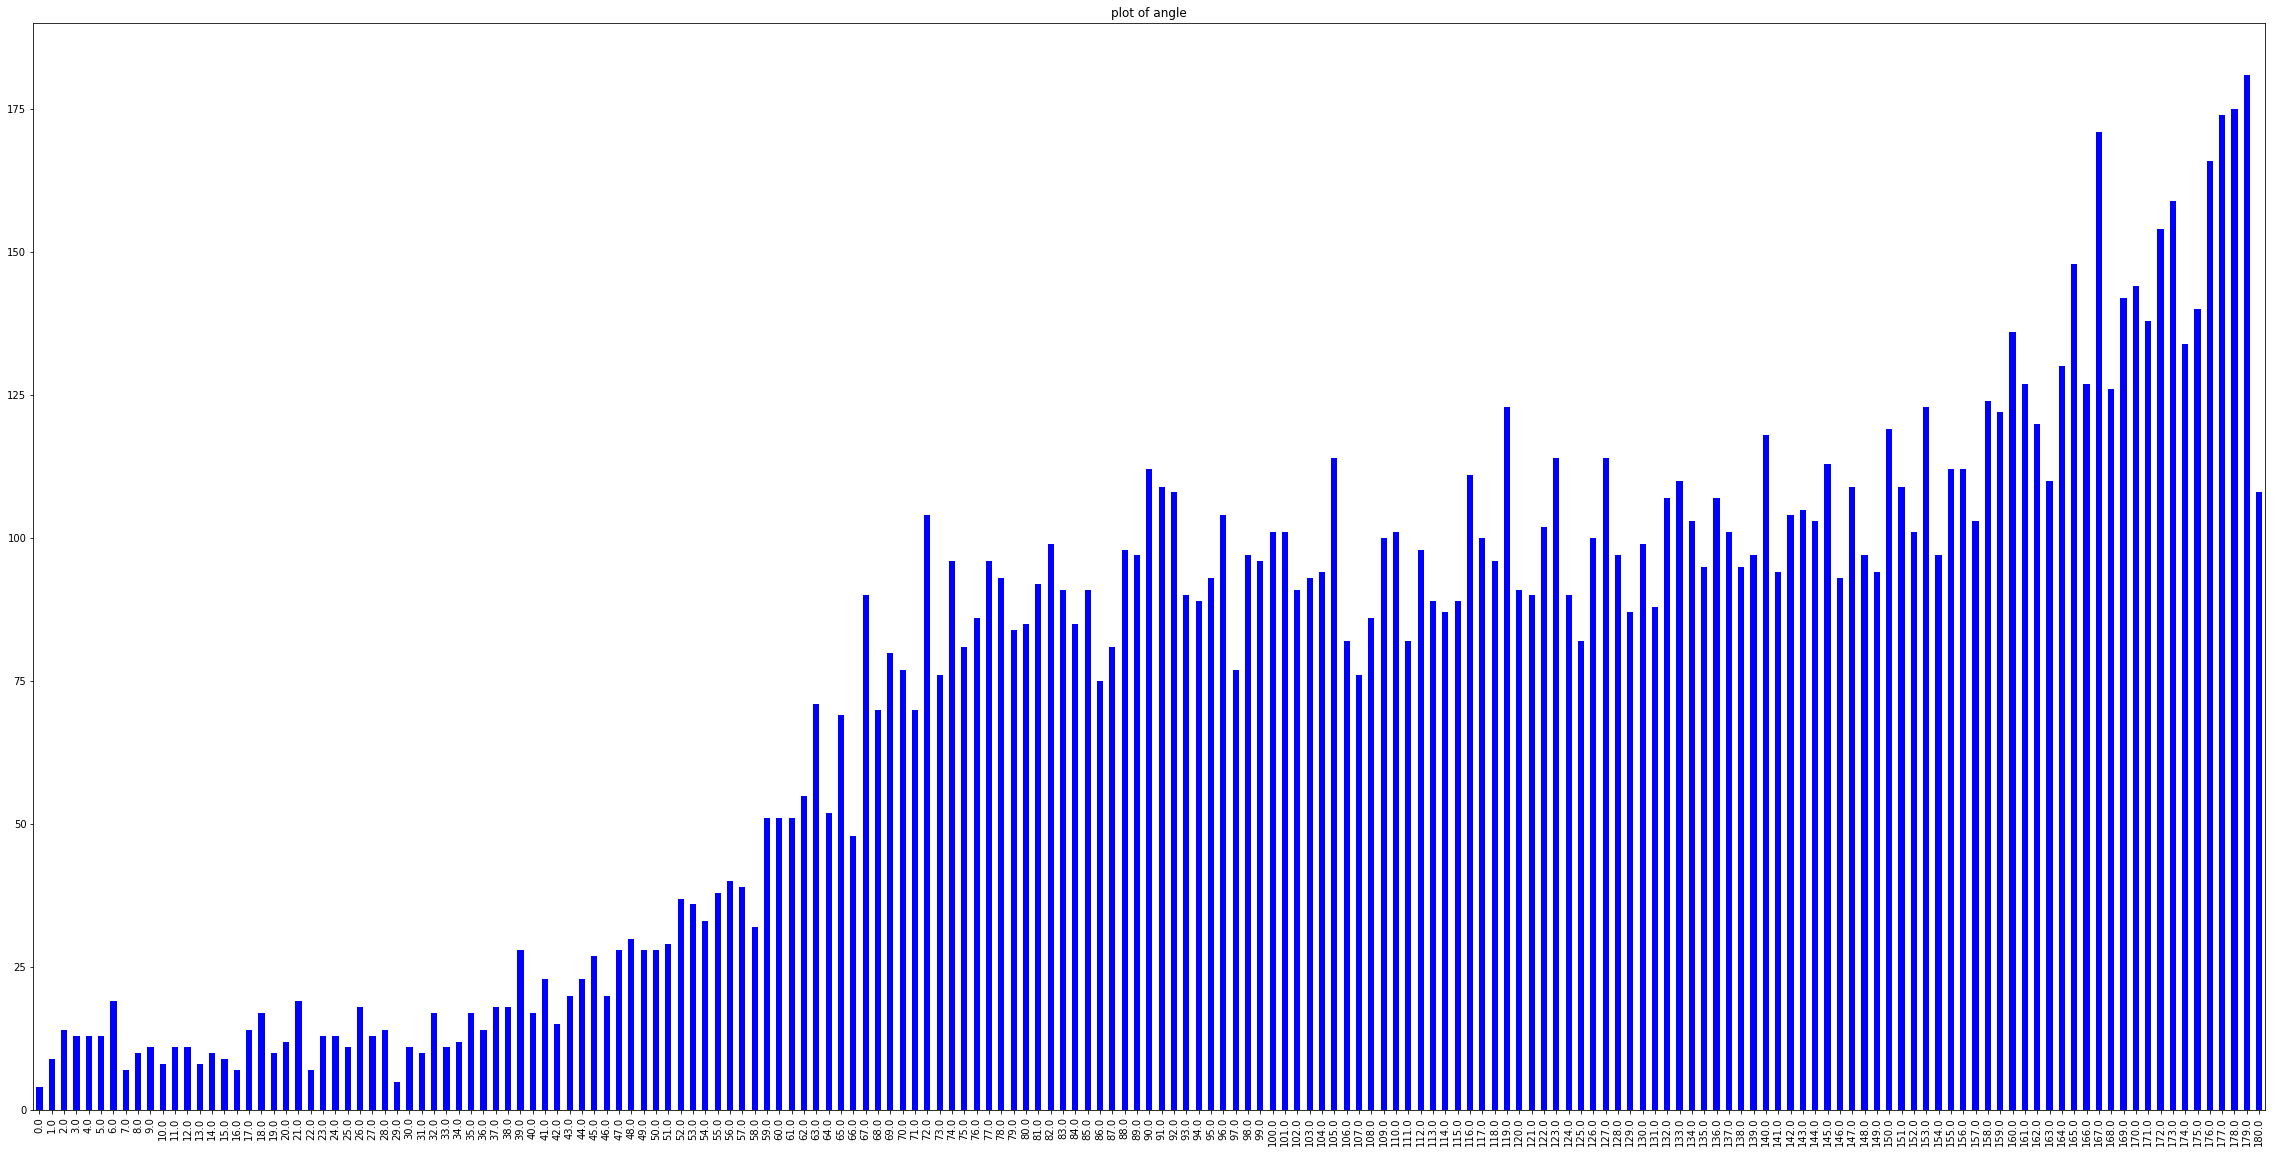

In [9]:
import numpy as np
df = df.reindex(np.array(solution_list).astype(int))
# If last index is not equal to first index
df['combined'] = list(zip(df['City x-Coord'], df['City y-Coord']))
# df['combined'] = df[['City x-Coord', 'City y-Coord']].values.tolist()
df['combined'] = df['combined'].apply(np.array)
a = df['combined'] - df['combined'].shift(1)
b = df['combined'] - df['combined'].shift(-1)
df['angle'] = [np.degrees(np.arccos(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y)))).round().astype(int) for
               x, y in zip(a, b)]
df['difference_cities'] = [np.linalg.norm(x-y).round(3) for x, y in zip(df['combined'],df['combined'].shift(1))]
df['prev city coordinate']=[x for x in df['combined'].shift(1)]
df.iloc[0, df.columns.get_loc('angle')]=np.NaN
df.iloc[-1, df.columns.get_loc('angle')]=np.NaN
#We ignore 1st and last values
df_for_plot=df.copy(deep=True)
df_for_plot['angle'][1:-1,].value_counts().sort_index().plot(kind = 'bar',
                                                 color = 'b',
                                                 sort_columns = True,
                                                 title = "plot of angle", figsize=(40,20))
plt.show()

In [10]:
def func(ax, row):
    x1=row['combined'][0]
    x2=row['prev city coordinate'][0]
    y1=row['combined'][1]
    y2=row['prev city coordinate'][1]
    ax.plot([x1,x2],[y1,y2], color='red', marker='o', linewidth=4)

### Plotting of cities and travel taken as by tsp solution

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 5000)

df2 = pd.DataFrame(pd.np.zeros((len(df.index), ))).set_index(df.index)
for i in df.index:
    df2[i] = [df['coord'][x] - df['coord'][i] for x in df.index]
df2 = df2.abs().round(1)
df2.drop([0], axis=1, inplace=True)

### Calculate the rank of every distance and store it in same cell inside the notebook.

In [12]:
# Calculate distance
# Change distance by the rank
for i in df2.index:
    df2.loc[i] = df2.loc[i].rank(ascending=1)
    df2.loc[i] -= 1 # start from 0th rank
# Convert float to integer
df2 = df2.round().astype(int)

### Combine the vertices together as it appears in the tsp solution and update rank correspondingly.

In [13]:
a=df.index.values
a=pd.Series(a).shift(1)
df['combined indices']=[[int(x),y] if not np.isnan(x) else [np.NaN, 1] for x,y in zip(a,df.index.values)]
df=df.astype(object)
df['rank']=[df2.loc[x][y] if not np.isnan(x) else -1 for x,y in df['combined indices']]

### Plot the count of distance rank's as its being used in tsp solution.

We plot count of where 1st neighbour is selected in tsp solution, then second neighbour, followed by third neighbour and hence forth. We see, that in case of first neighbour, the count is highest and it decreases exponentially as expected.

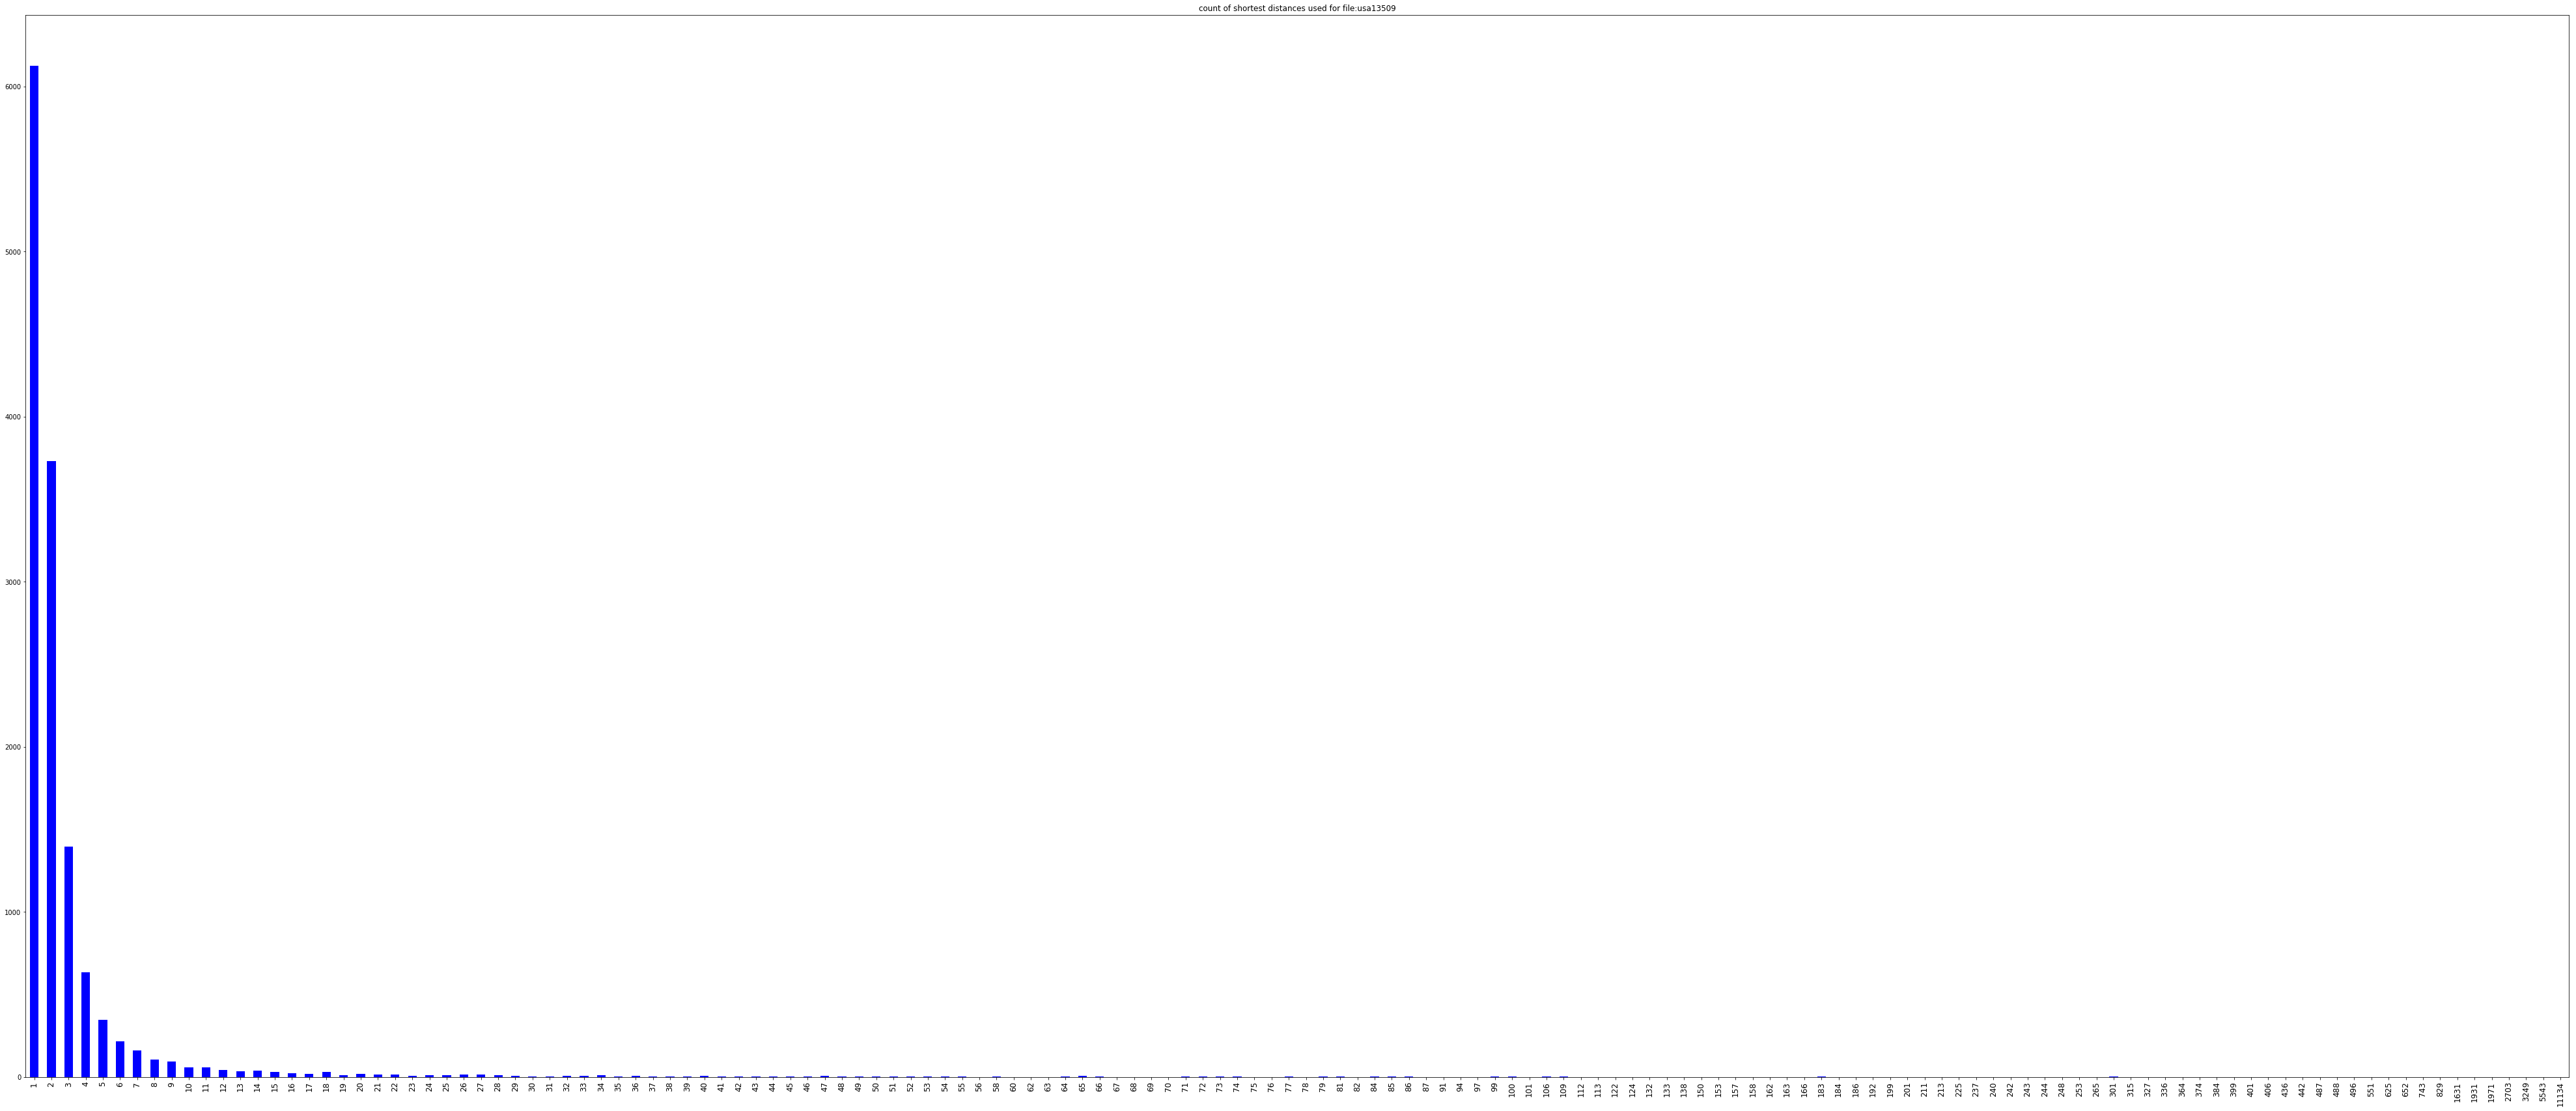

In [14]:
df3=df.iloc[1:,]
title = "count of shortest distances used for file:{}".format(file)
ax=df3['rank'].value_counts(sort=False).sort_index().plot(kind='bar',
                         color='b',
                         title=title,figsize=(70, 30))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
plt.show()

### Plotting the cities

We go on plotting the cities on the map. The connections with are farthest neighbours are colored 'red'. For example, if number_of_farthest_neighbour_connections_to_choose is 3, then connections which are 3rd farthest(3249th neighbour, 5543th neighbour and 11134th neighbour are colored 'red').

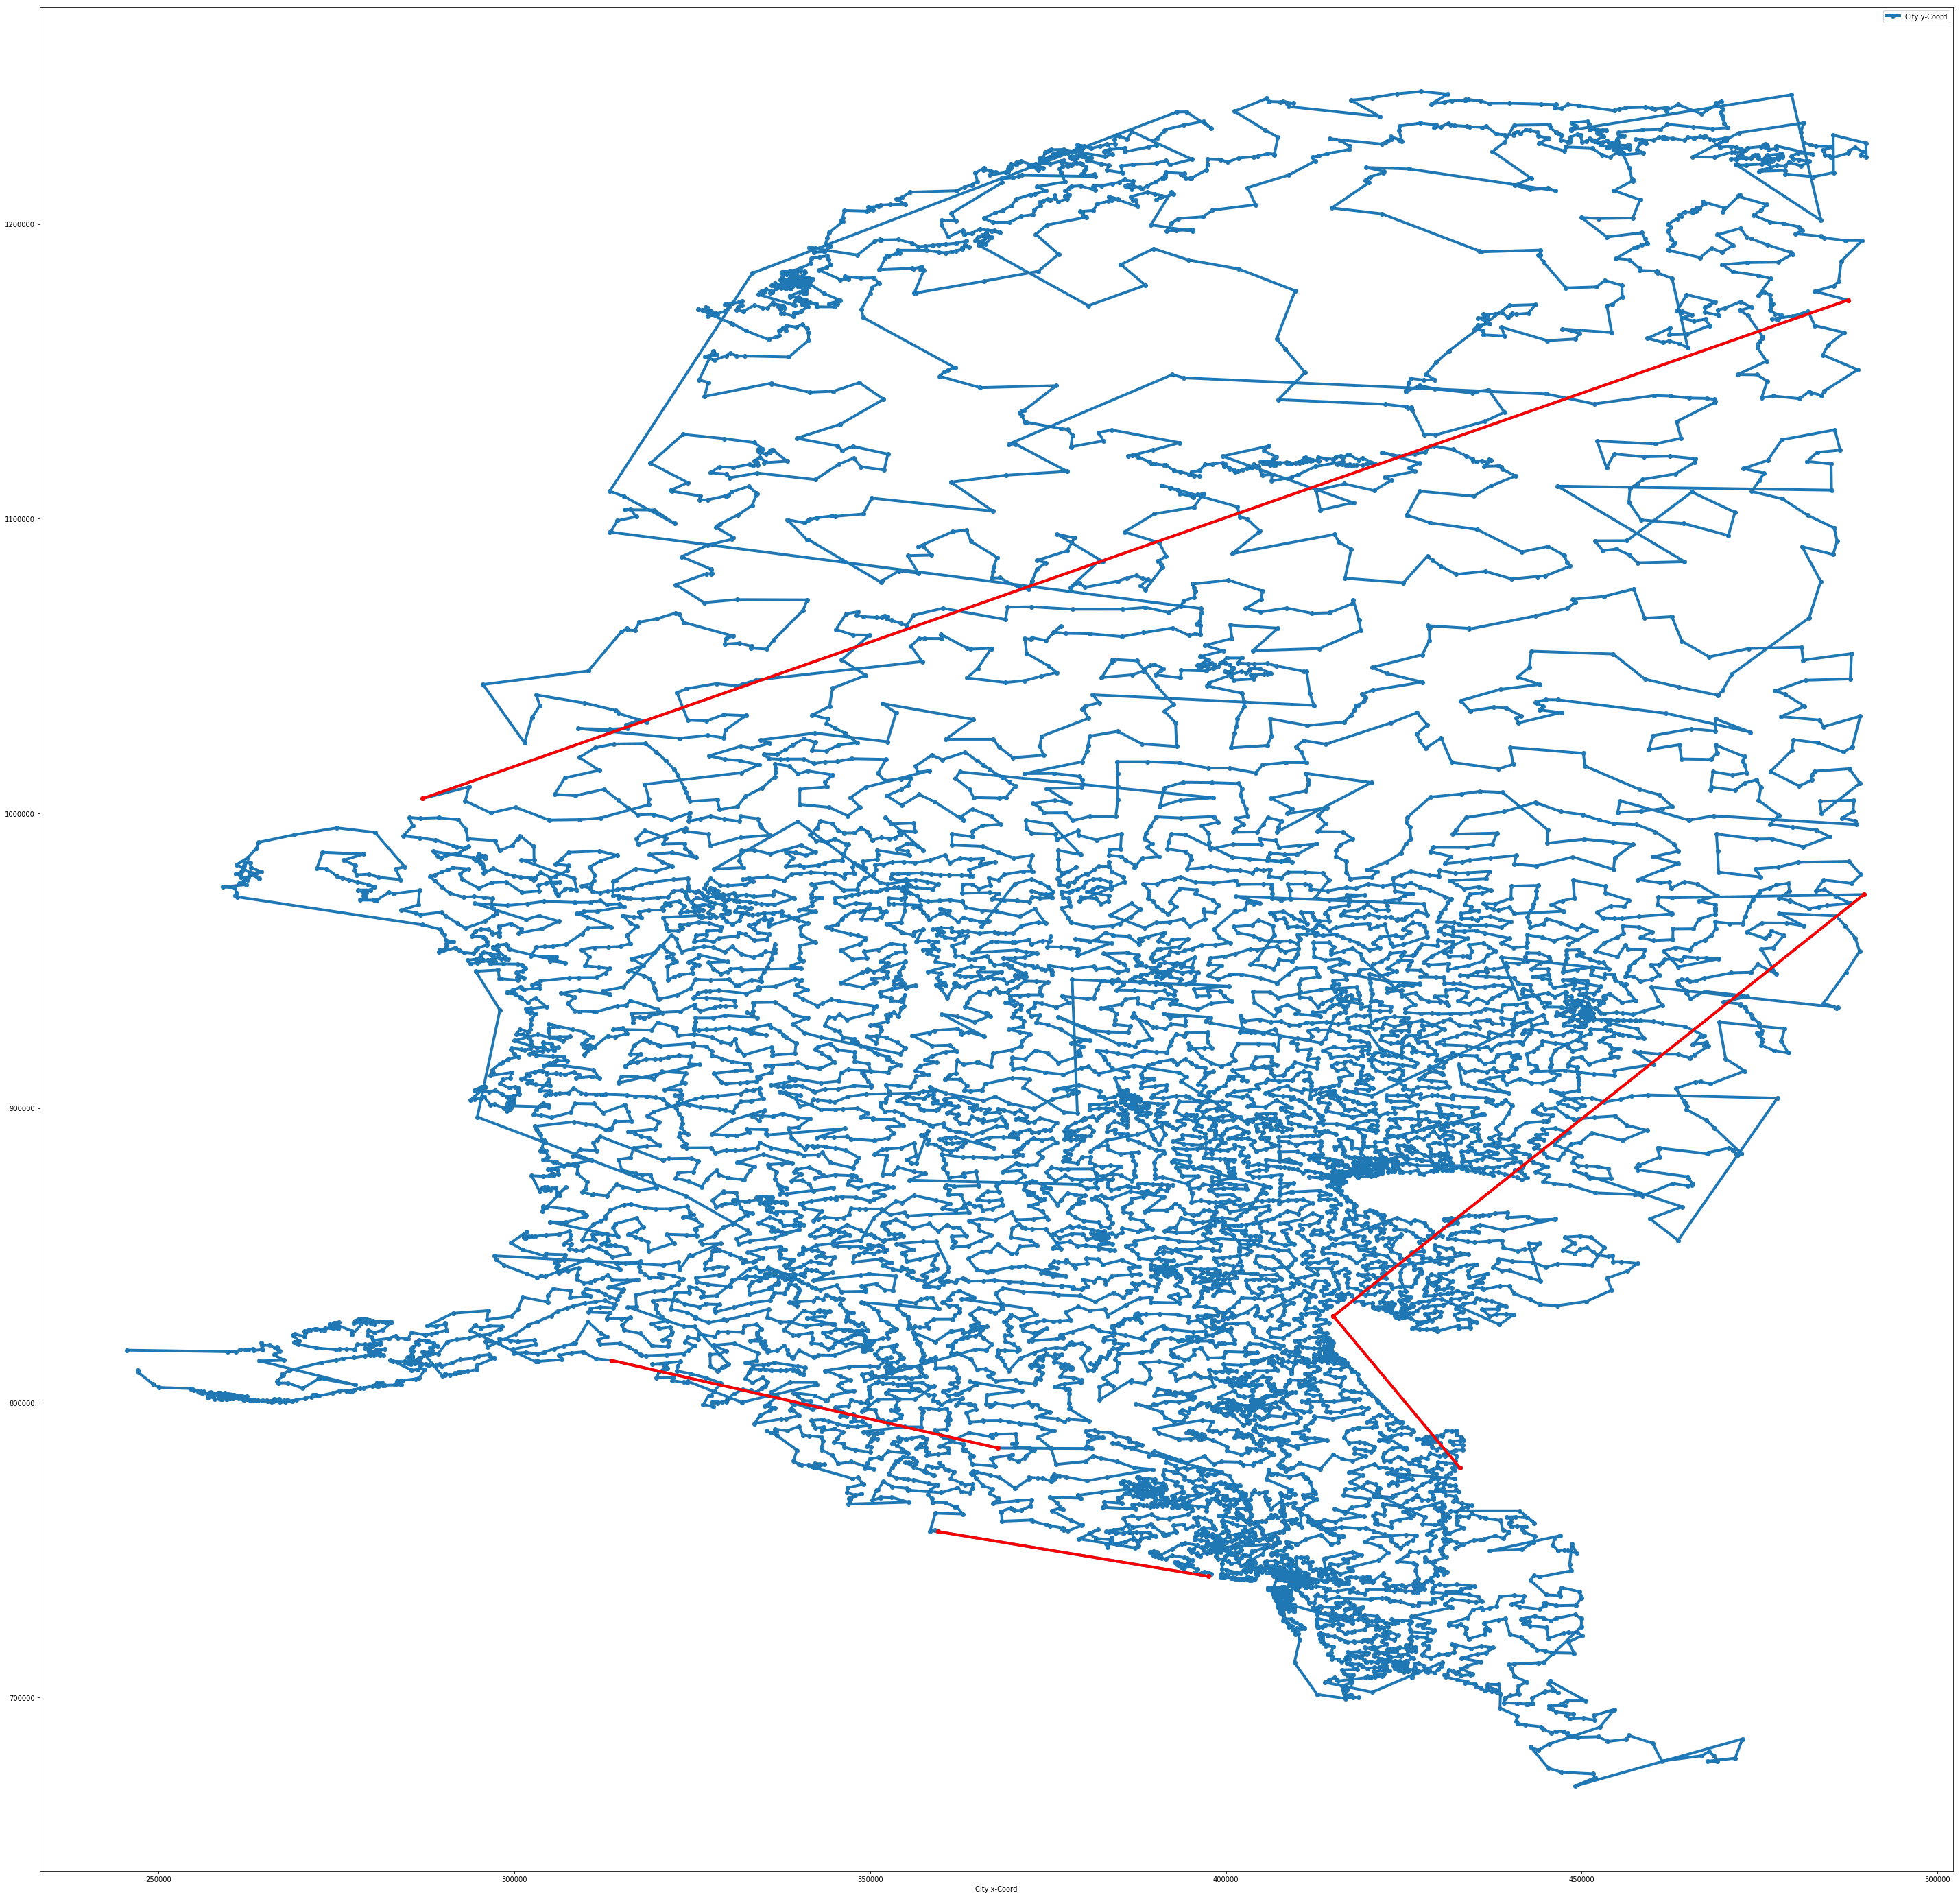

In [15]:
if number_of_farthest_neighbour_connections_to_choose >= df3['rank'].nunique():
    number_of_farthest_neighbour_connections_to_choose = df3['rank'].nunique()
ax=df_for_plot.plot(x='City x-Coord', y='City y-Coord', marker='o',
                  figsize=(50, 50), linewidth=4)
rank_to_be_filtered = np.sort(df['rank'].unique())[-number_of_farthest_neighbour_connections_to_choose:]
df_largest_n_elements = df.loc[df['rank'].isin(rank_to_be_filtered)]
df_largest_n_elements.apply(lambda x:func(ax,x), axis=1)
plt.show()